# ResNet50 Model

In this model, starting from the pre-trained ResNet50 model will be the approach.

### Loading and preparation of the dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from utils import check_device, make_dataset
from models import cnn_model as cnn
from visualization import visualize

torch.manual_seed(126)
np.random.seed(126)

In [2]:
device = check_device.set_device()
print(device)

cuda


In [3]:
path_dir = "../../kaggle/pneumoniaDataset/chest_xray"

train_data_dir, test_data_dir = make_dataset.path_dataset(path_dir)

The path ../../kaggle/pneumoniaDataset/chest_xray is valid.


In [4]:
images, labels = make_dataset.load_chest_xray_data( train_data_dir )
images_test, labels_test = make_dataset.load_chest_xray_data( test_data_dir )

In [5]:
# To convert to a NumPy array
# Training test
np_images = np.array(images, dtype=object)
np_labels = np.array(labels, dtype=object)
# Testing set
np_images_test = np.array(images_test, dtype=object)
np_labels_test = np.array(labels_test, dtype=object)

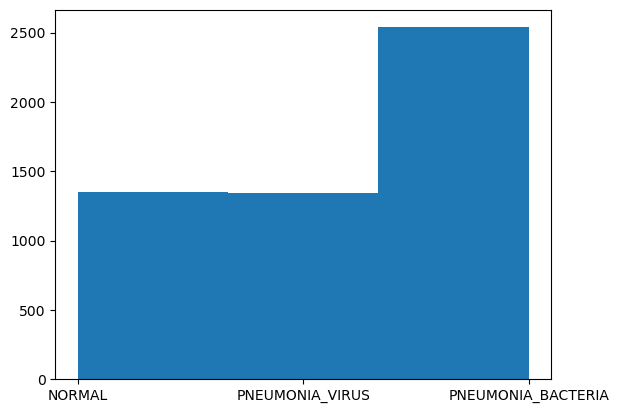

In [6]:
plt.hist(np_labels, len(set(np_labels)))
plt.show()

### Image preprocessing

In [7]:
img_size = (380, 380)

# Preprocessing of images
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(img_size),
                                transforms.RandomApply(torch.nn.ModuleList([
                                    transforms.RandomRotation(degrees=30),
                                    ]), p=0.25),
                                    #transforms.RandomCrop((224, 224))
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

transform_test = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

# The data sets (training and test) are extracted using the torchvision.datasets library.
train_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_dir, transform=transform_test)


# The training set is divided into training data and validation data.
train_set, validation_set = random_split(train_dataset, 
                                                 (int(len(train_dataset) * 0.8)+1,
                                                 int(len(train_dataset) * 0.2)))

# The dataset is wrapped in an iterable for better access to samples in the training set.
batch_size = 12
train_dataloader = DataLoader( train_set, batch_size=batch_size, shuffle=True )
valid_dataloader = DataLoader( validation_set, batch_size=batch_size, shuffle=True )
test_dataloader = DataLoader( test_dataset, batch_size=batch_size)

### Definition of the CNN architecture

Application of weights to the loss function to prevent biases in the model:

In [8]:
normal, bacteria, virus, total = visualize.count_labels(labels)

# class weights inversely proportional to frequency
class_weights = 1.0 / torch.tensor([normal, virus, bacteria], dtype=torch.float)

# Normalize weights to sum up to 1
class_weights = class_weights / class_weights.sum()

# Create the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

#### ResNet50 Architecture

In [9]:
# Model instance
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The gradients are set to False for the pre-trained layers to prevent them from being modified during training. Only the weights of the newly added or modified layers are intended to be optimized.

In [10]:
for param in model.parameters():
    param.requires_grad = False

The model's layers are being fine-tuned to fit the training data.

In [11]:
num_ftrs = model.fc.in_features
model.conv1 = nn.Conv2d(in_channels=1,
                      out_channels=64,
                      kernel_size=7,
                      stride=2,
                      padding=3,
                      bias=False
            )
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 712),
    nn.ReLU(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(712, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(p=0.5, inplace=False),
    #nn.Linear(32, 256),
    #nn.ReLU(),
    #nn.Dropout(p=0.5, inplace=False),
    
    nn.Linear(32, 3),

    nn.Softmax(dim=1)  
)

model = model.to(device)
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Hyperparameters

For training, the samples have been processed in batches of 64, using a learning rate of 0.001. The dataset will be iterated over a total of 50 times unless it stops prematurely upon observing that the model does not improve after a given number of epochs.

In [12]:
learning_rate = 0.001  # 1e-3
epochs = 50

In [13]:
# Initialize the loss function
weight=class_weights
weight = weight.to(device)

train_criterion = nn.CrossEntropyLoss(weight)
test_criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

### Train Loop

In [14]:
hist = cnn.train_model(model, train_dataloader, valid_dataloader, train_criterion, optimizer, scheduler, epochs)

Epoch 1 / 50 
-------------------------------
loss: 1.079944  [    0/ 4186]
loss: 1.143289  [  768/ 4186]
loss: 1.151708  [ 1536/ 4186]
loss: 0.946832  [ 2304/ 4186]
loss: 1.130998  [ 3072/ 4186]
loss: 0.932767  [ 3840/ 4186]
Test Error: 
 Accuracy: 58.2%, Avg loss: 0.881551 

Epoch 2 / 50 
-------------------------------
loss: 1.006855  [    0/ 4186]
loss: 0.690374  [  768/ 4186]
loss: 0.767201  [ 1536/ 4186]
loss: 0.775759  [ 2304/ 4186]
loss: 0.818112  [ 3072/ 4186]
loss: 0.851649  [ 3840/ 4186]
Test Error: 
 Accuracy: 66.7%, Avg loss: 0.788684 

Epoch 3 / 50 
-------------------------------
loss: 0.686044  [    0/ 4186]
loss: 0.912894  [  768/ 4186]
loss: 0.738473  [ 1536/ 4186]
loss: 0.879964  [ 2304/ 4186]
loss: 1.174343  [ 3072/ 4186]
loss: 0.651402  [ 3840/ 4186]
Test Error: 
 Accuracy: 65.2%, Avg loss: 0.806963 

Epoch 4 / 50 
-------------------------------
loss: 0.701781  [    0/ 4186]
loss: 0.985072  [  768/ 4186]
loss: 0.891045  [ 1536/ 4186]
loss: 0.644968  [ 2304/ 4186]


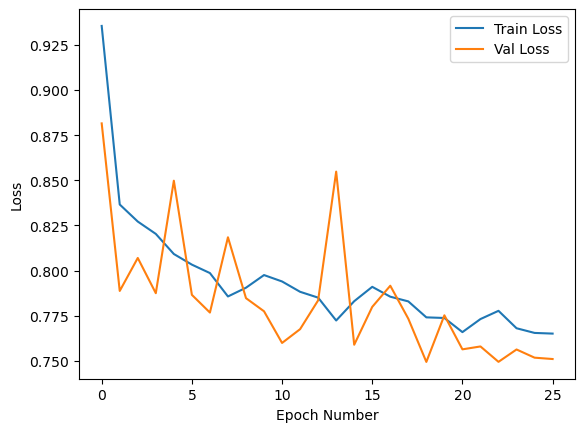

In [15]:
visualize.plot_loss_history(hist)

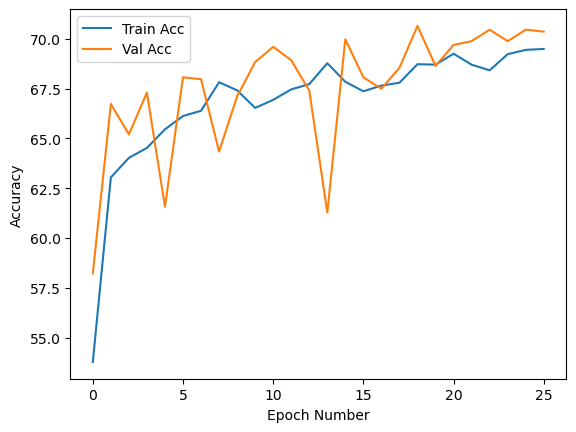

In [16]:
visualize.plot_accuracy_history(hist)

## Testing

Reading the stored model and performing the tests.

In [17]:
checkpoint = torch.load('../models/model_checkpoint.pth.tar')

In [18]:
print(checkpoint['epoch'])
print(checkpoint['accuracy'])

19
70.65009560229446


In [19]:
# Loading the model
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [20]:
# Test
accuracy, test_loss, true_labels, pred_labels = cnn.test_model(test_dataloader, model, test_criterion)

Test evaluation:
Test Error: 
 Accuracy: 67.6%, Avg loss: 0.872055 

Done!


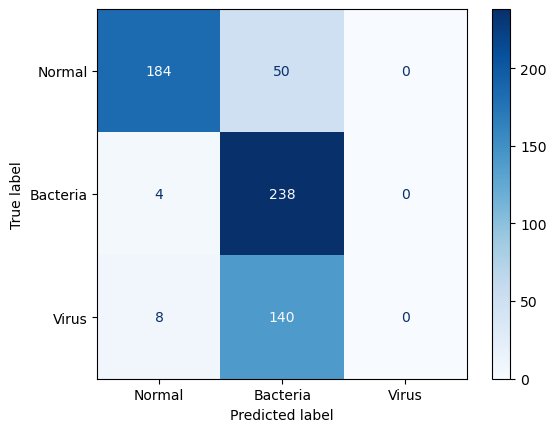

In [21]:
cm = confusion_matrix(true_labels, pred_labels)

classes=['Normal', 'Bacteria', 'Virus']
cmDisplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cmDisplay.plot(cmap="Blues")
plt.show()

In [22]:
print(classification_report(true_labels, pred_labels, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.94      0.79      0.86       234
    Bacteria       0.56      0.98      0.71       242
       Virus       0.00      0.00      0.00       148

    accuracy                           0.68       624
   macro avg       0.50      0.59      0.52       624
weighted avg       0.57      0.68      0.60       624



/home/miguel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/miguel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/miguel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Image classifier

Random images are chosen to visually verify some results of the model.

In [23]:
im_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize(img_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

image: VIRUS-30184-0001.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.2119 | Virus: 0.5761 | Bacteria: 0.2119


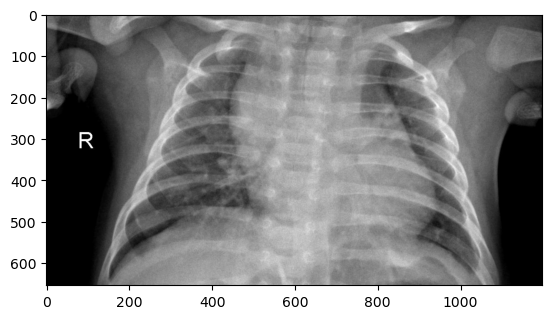

In [24]:
# Check a random sample
classes = ['NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS']

visualize.classify_random_image(model, im_transform, '../../kaggle/pneumoniaDataset/chest_xray/test/', classes, device)

image: NORMAL-2870844-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.5761 | Virus: 0.2119 | Bacteria: 0.2119


image: BACTERIA-1768914-0006.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.2119 | Virus: 0.5761 | Bacteria: 0.2119


image: VIRUS-1352878-0005.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.2119 | Virus: 0.5761 | Bacteria: 0.2119


image: NORMAL-4834475-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.5761 | Virus: 0.2119 | Bacteria: 0.2119


image: NORMAL-6874528-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.5761 | Virus: 0.2119 | Bacteria: 0.2119


image: BACTERIA-7051071-0002.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.2119 | Virus: 0.5761 | Bacteria: 0.2119


image: NORMAL-5175014-0001.jpeg
pred: NORMAL
-Softmax: 
Normal: 0.5761 | Virus: 0.2119 | Bacteria: 0.2119


image: BACTERIA-9156003-0004.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.2119 | Virus: 0.5761 | Bacteria: 0.2119


image: VIRUS-2040583-0001.jpeg
pred: PNEUMONIA_BACTERIA
-Softmax: 
Normal: 0.2119 |

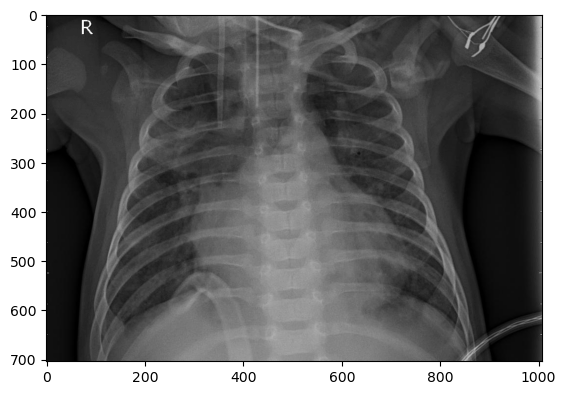

In [25]:
# Check random samples
for i in range(10):
    visualize.classify_random_image(model, im_transform, '../../kaggle/pneumoniaDataset/chest_xray/test/', classes, device)
    print("\n")

In [26]:
torch.cuda.empty_cache()